In [45]:
# Cargando las librerías principales

import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
 # Cargando los datos
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                     train=True, 
                                     transform=transforms.ToTensor(),  
                                     download=True)

 # Cargando los datos
validation_dataset = torchvision.datasets.MNIST(root='./data', 
                                     train=True, 
                                     transform=transforms.ToTensor(),  
                                     download=True)

 # Cargando los datos
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                     train=False,
                                     transform=transforms.ToTensor(),  
                                     download=True)

validation_size=0.1
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(validation_size * num_train))
np.random.shuffle(indices)

train_idx, validation_idx = indices[split:], indices[:split]

validation_size=0.1
print("Trainning samples",len(train_idx))
print("validation samples",len(validation_idx))
print("Testing samples",len(test_dataset))

Trainning samples 54000
validation samples 6000
Testing samples 10000


In [3]:
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)


# Loader para generar los batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=100,
                                          sampler=train_sampler)
# Loader para generar los batches
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                          batch_size=100,
                                          sampler=validation_sampler)


# Loader para generar los batches
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=100, 
                                          shuffle=True)

In [4]:
# Definiendo el device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet().to(device)

In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  

In [7]:
# Conección con tensorborad
writer = SummaryWriter()

In [8]:
train_iter = iter(train_loader)
iter_per_epoch = len(train_loader)
iters=10
total_steps=int(5*len(train_idx)/100)
model.train()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [75]:
for step in range(total_steps):
    if (step+1) % len(train_idx) == 0:
        print("Iter:",step/len(train_idx)+1)
        
    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(train_loader)

    # Fetch images and labels
    try:
        images, labels = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        images, labels = next(train_iter)
    
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute accuracy
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()
    
    
    if (step+1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs_ = model(images)
                loss_ = criterion(outputs_, labels)
            
            _, argmax_ = torch.max(outputs_, 1)
            accuracy_ = (labels == argmax_.squeeze()).float().mean()
            
        
        print ('Step [{}/{}], Loss: {:.4f}, Acc: {:.2f}, val Loss: {:.4f}, val Acc: {:.2f}' 
               .format(step+1, total_steps, loss.item(), accuracy.item(),loss_.item(),accuracy_.item()))
        
        writer.add_scalar('train/loss', loss, step+1)
        writer.add_scalar('train/acc', accuracy, step+1)
        writer.add_scalar('valid/loss', loss_, step+1)
        writer.add_scalar('valid/acc', accuracy_, step+1)
        
        # 2. Log values and gradients of the parameters (histogram summary)
        for tag, value in model.named_parameters():
            tag = tag.replace('.', '/')
            writer.add_histogram(tag, value.data.cpu().numpy(), step+1)
            writer.add_histogram(tag+'/grad', value.grad.data.cpu().numpy(), step+1)
        model.train()

Step [100/2700], Loss: 0.3934, Acc: 0.88, val Loss: 0.3249, val Acc: 0.90
Step [200/2700], Loss: 0.3385, Acc: 0.94, val Loss: 0.3929, val Acc: 0.92
Step [300/2700], Loss: 0.3229, Acc: 0.96, val Loss: 0.3626, val Acc: 0.94
Step [400/2700], Loss: 0.3538, Acc: 0.95, val Loss: 0.3563, val Acc: 0.92
Step [500/2700], Loss: 0.4062, Acc: 0.92, val Loss: 0.4153, val Acc: 0.91
Step [600/2700], Loss: 0.3387, Acc: 0.94, val Loss: 0.3825, val Acc: 0.93
Step [700/2700], Loss: 0.3349, Acc: 0.94, val Loss: 0.3585, val Acc: 0.96
Step [800/2700], Loss: 0.2798, Acc: 0.97, val Loss: 0.2805, val Acc: 0.96
Step [900/2700], Loss: 0.2828, Acc: 0.95, val Loss: 0.3039, val Acc: 0.94
Step [1000/2700], Loss: 0.3226, Acc: 0.92, val Loss: 0.3055, val Acc: 0.93
Step [1100/2700], Loss: 0.2260, Acc: 0.98, val Loss: 0.2495, val Acc: 0.96
Step [1200/2700], Loss: 0.2662, Acc: 0.95, val Loss: 0.2494, val Acc: 0.94
Step [1300/2700], Loss: 0.2282, Acc: 0.98, val Loss: 0.2692, val Acc: 0.95
Step [1400/2700], Loss: 0.3474, Ac

In [11]:
# Evaluación test

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs_ = model(images)
        loss_ = criterion(outputs_, labels)
            
        _, argmax_ = torch.max(outputs_, 1)
        accuracy_ = (labels == argmax_.squeeze()).float().mean()
        
print ('Evaluation Loss: {:.4f}, Acc: {:.2f}' 
               .format(loss_.item(),accuracy_.item()))

Evaluation Loss: 0.3027, Acc: 0.94


In [12]:
torch.onnx.export(model, images, "cnn.onnx")

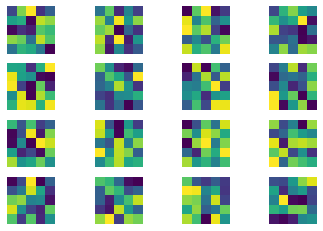

In [54]:
kernels = model.layer1[0].weight.detach()
fig, axarr = plt.subplots(4,4)
for idx in range(4):
    for idy in range(4):
        axarr[idx,idy].imshow(kernels[idx*4+idy].squeeze())
        axarr[idx,idy].axis('off')

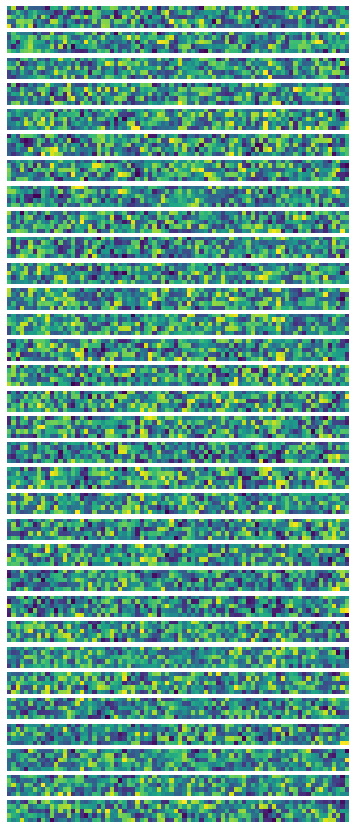

In [55]:
kernels = model.layer2[0].weight.detach()
fig, axarr = plt.subplots(32,figsize=(30,15))
for idx in range(32):
    vals=[]
    for idy in range(16):
        vals.append(kernels[idx][idy].squeeze())
    axarr[idx].imshow(np.hstack(vals))
    axarr[idx].axis('off')


In [57]:
validation_iter = iter(validation_loader)
images, labels = next(validation_iter)
image=images[20]
image.unsqueeze_(0)
image = Variable(image, requires_grad=True)
print(image.size())

torch.Size([1, 1, 28, 28])


In [58]:
conv1_out = model.layer1[0].forward(image)
print(conv1_out.size())

torch.Size([1, 16, 28, 28])


In [59]:
filter_images = conv1_out.cpu().detach().clone()
fig, axarr = plt.subplots(4,4)
for idx in range(4):
    for idy in range(4):
        axarr[idx,idy].imshow(filter_images[0][idx*4+idy].squeeze())
        axarr[idx,idy].axis('off')

In [60]:
layer1_out = model.layer1.forward(image)
conv2_out = model.layer2[0].forward(layer1_out)

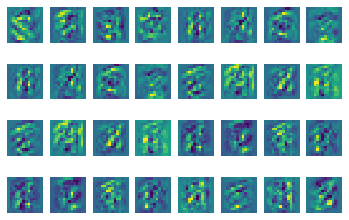

In [61]:
filter_images = conv2_out.cpu().detach().clone()
fig, axarr = plt.subplots(4,8)
for idx in range(4):
    for idy in range(8):
        axarr[idx,idy].imshow(filter_images[0][idx*4+idy].squeeze())
        axarr[idx,idy].axis('off')

In [64]:
layer2_out = model.layer2.forward(layer1_out)
print(layer2_out.size())

torch.Size([1, 32, 7, 7])


In [65]:
filter_images = layer2_out.cpu().detach().clone()
fig, axarr = plt.subplots(4,8)
for idx in range(4):
    for idy in range(8):
        axarr[idx,idy].imshow(filter_images[0][idx*4+idy].squeeze())
        axarr[idx,idy].axis('off')

In [74]:
nn_out = model.fc.forward(layer2_out.reshape(layer2_out.size(0), -1))
print("Tamaño última capa:",nn_out.size())
print("Pesos de salida:",nn_out)
print("Calse seleccionada:",torch.argmax(nn_out,1))

Tamaño última capa: torch.Size([1, 10])
Pesos de salida: tensor([[-0.6642, -3.1685, -0.8760,  0.8614, -2.2717,  0.3578, -1.6941, -2.1461,
          1.7321, -0.9105]], grad_fn=<AddmmBackward>)
Calse seleccionada: tensor([8])
